In [33]:
# %load bounding_boxes.py
'''
Created on Apr 23, 2015

    Bounding boxes from extracted video images

@author: Francois
'''

import cPickle as pickle
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

% matplotlib inline
#
#    Extract bounding boxes from pre-processed image
#
#    @param seg A gray scale image
#    @param thr The threshold value (90 to 110 is reasonnable) for contour detection
#    @param blur Blur radius in number of pixels
#
#    @return List of bounding box coordinates (cv2 rectangles)
#
def get_bbx(seg, thr = 100, blur = 6):
    #
    #    Normalized picture
    #
    norm_pct =  np.copy(seg)
    norm_pct += np.abs(np.min(norm_pct))
    norm_pct =  255.0 * norm_pct / float(np.max(norm_pct) - np.min(norm_pct))
    norm_pct =  norm_pct.astype(np.uint8)
    #
    #    Blur the picture
    #
    blurred_pct = cv2.blur(norm_pct, (blur, blur))
    #
    #    Extract thresholds
    #
    ret, thresh1 = cv2.threshold(blurred_pct, thr, 255, cv2.THRESH_TOZERO_INV)
    ret, thresh2 = cv2.threshold(blurred_pct, 255 - thr, 255, cv2.THRESH_TOZERO)
    thresh = np.zeros(norm_pct.shape, dtype = np.uint8)
    thresh[:] = ((thresh1 + thresh2) * 0.5 )[:]
    #
    #    Extract contours
    #
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #
    #    Return list of contours
    #
    return contours, hier
#
#   Example
#
input_folder = '../processed_imgs/'
output_folder = '../region_proposals/'
frame = 80
#
dump = pickle.load(open('%sseg_example_%d.pi' % (input_folder, frame), 'rb'))
#
seg         = dump['seg']
original    = dump['original'].astype(np.uint8)

#
# Parameters to play around with
#
aspect_ratio = original.shape[1] / float(original.shape[0])
min_width_bounding_rect = 10
min_height_bounding_rect = 10
min_width_ratio_padding = .25
min_width_pixel_padding = 20
min_height_ratio_padding = aspect_ratio * .25
min_height_pixel_padding = aspect_ratio * 20
nms_overlap_threshold = .4

#
contours, hier = get_bbx(seg)
hier = np.squeeze(hier)
#
boxes = []
kept_contours = []
for i in range(len(contours)):
    if hier[i,3] >= 0:
        # Check if contour has parent. If so, skip
        continue
    rect = cv2.boundingRect(contours[i])
    x, y, w, h = rect
    # skip boxes that are too small:
    if w < min_width_bounding_rect or h < min_height_bounding_rect:
        continue
    const_x = max(min_width_ratio_padding * w, min_width_pixel_padding)
    const_y = max(min_height_ratio_padding * h, min_height_pixel_padding)
    y_b = max(y - const_y, 0)
    y_e = min(y + h + const_y, original.shape[0])
    x_b = max(x - const_x, 0)
    x_e = min(x + w + const_x, original.shape[1])
    boxes.append(np.array([x_b, y_b, x_e, y_e]))
    kept_contours.append(i)

boxes = np.array(boxes)
kept_contours = np.array(kept_contours)

In [34]:
# http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]

	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int"), pick

(17, 4) (7, 4)
[ 1  6  8 29 26 37 38]


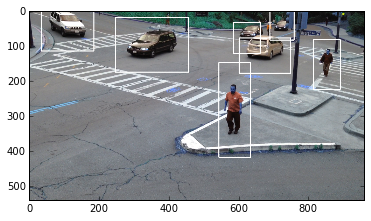

In [35]:
nms_kept_boxes, nms_kept = non_max_suppression_fast(boxes, nms_overlap_threshold)
nms_kept_contours = kept_contours[nms_kept]
print boxes.shape, nms_kept_boxes.shape
print nms_kept_contours

sub_picts = []
original_with_boxes = np.copy(original)
for box in nms_kept_boxes:
    x_b, y_b, x_e, y_e = box
    sub_pict = original[y_b:y_e, x_b:x_e]
    sub_picts.append(sub_pict)
    cv2.rectangle(original_with_boxes, (int(x_b), int(y_b)), (int(x_e), int(y_e)), (255, 255, 255), 2)

for i, sub_pict in enumerate(sub_picts):
    cv2.imwrite(output_folder + '/%d_%d_bbx.png' % (frame, i), sub_pict)
plt.imshow(original_with_boxes)

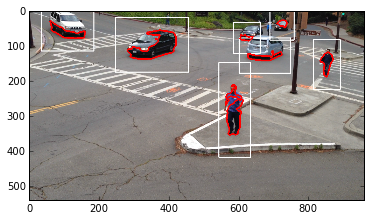

In [36]:
original_with_contours = np.copy(original_with_boxes)
for i in nms_kept_contours:
    cv2.drawContours(original_with_contours, contours, i, (0, 0, 255), 3)
original_with_contours = original_with_contours[:,:,[2,1,0]]
plt.imshow(original_with_contours)

In [29]:
print nms_kept_boxes

[[  0 114 362 423]
 [476  94 588 322]
 [352 124 412 248]
 [732  66 939 236]
 [102  27 168 145]
 [515  11 747 119]
 [  0   0  43 106]
 [101   0 261  95]]


In [ ]:
"""
TODO: try merging boxes/contours?
countour hierarchy doesn't help much because almost all contours are just at the top level.
"""

In [47]:
# Shortened version of code above.
def output_bounding_boxes(frame):
    # Get Frame image
    dump = pickle.load(open('%sseg_example_%d.pi' % (input_folder, frame), 'rb'))
    seg         = dump['seg']
    original    = dump['original'].astype(np.uint8)

    # Get Contours
    contours, hier = get_bbx(seg)
    hier = np.squeeze(hier)

    # Get bounding boxes with padding. Filter out small boxes.
    boxes = []
    for i in range(len(contours)):
        if hier[i,3] >= 0:
            # Check if contour has parent. If so, skip
            continue
        rect = cv2.boundingRect(contours[i])
        x, y, w, h = rect
        # skip boxes that are too small:
        if w < min_width_bounding_rect or h < min_height_bounding_rect:
            continue
        const_x = max(min_width_ratio_padding * w, min_width_pixel_padding)
        const_y = max(min_height_ratio_padding * h, min_height_pixel_padding)
        y_b = max(y - const_y, 0)
        y_e = min(y + h + const_y, original.shape[0])
        x_b = max(x - const_x, 0)
        x_e = min(x + w + const_x, original.shape[1])
        boxes.append(np.array([x_b, y_b, x_e, y_e]))

    boxes = np.array(boxes)

    # Perform nms
    nms_kept_boxes, nms_kept = non_max_suppression_fast(boxes, nms_overlap_threshold)

    # Get bounding box images
    sub_picts = []
    for box in nms_kept_boxes:
        x_b, y_b, x_e, y_e = box
        sub_pict = original[y_b:y_e, x_b:x_e]
        sub_picts.append(sub_pict)

    # Write bounding box images to file
    for i, sub_pict in enumerate(sub_picts):
        cv2.imwrite(output_folder + '/%d_%d_bbx.png' % (frame, i), sub_pict)

In [48]:
frames = [47, 49, 52, 55, 60, 70, 80]
for frame in frames:
    output_bounding_boxes(frame)